In [92]:
import numpy as np
import numpy.random as rd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../Dan_research/spock')
from spock.modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
from spock.feature_functions import features
import rebound
import dask.dataframe as dd
from multiprocessing import Pool

n_workers=os.cpu_count()

In [93]:
os.system("jupyter nbconvert --to markdown Tutorial.ipynb");

# Generating fake systems

In [2]:
seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_p_solar_mass = 333000
year_p_reboundtime = 1 / (2 * np.pi)
AU_p_RS = 0.00465047

def replace_snapshot(sim, filename):
    if os.path.isfile(filename):
        os.remove(filename)
    sim.simulationarchive_snapshot(filename)
    
def loguniform(low=0.001, high=1, size=None):
    return np.exp(rd.uniform(np.log(low), np.log(high), size))

def max_e_inner(a_in, a_out, e_out=0):
    return a_out / a_in * (1 - e_out) - 1

def max_e_outer(a_out, a_in, e_in=0):
    return 1 - a_in / a_out * (1 + e_in)

def min_es(ms, As):
    Nplanets = len(ms)
    e_mins = np.zeros(Nplanets)
    for i in range(Nplanets):
        e_mins[i] = As[i] ** 2
        inner_sum = 0
        for j in range(Nplanets):
            if i != j:
                inner_sum += (ms[j] / np.max([As[i], As[j]]) ** 2) ** 2
        e_mins[i] *= np.sqrt(inner_sum)
    return e_mins

def check_es(a0, e0, a1, e1, a2, e2):
    return (e0 <= max_e_inner(a0, a1, e1)) and (e1 <= max_e_inner(a1, a2, e2)) and (e1 <= max_e_outer(a1, a0, e0)) and (e2 <= max_e_outer(a2, a1, e1))


def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0


"""
Generating random systems
Using methodolgy similar to Tamayo et al. 2020 (in prep)
"""
def generate_system():
    Mstar = 1
    mutual_hill_radii_sep = rd.uniform(0, 40, 2)
    incs = rd.uniform(1e-3, 1e-1, 3)  # inclinations (radians)
    Ws = 2 * np.pi * rd.rand(3)  # longitude of ascending node (radians)
    ws = 2 * np.pi * rd.rand(3)  # pericenter orientation (radians)
    Ms = 2 * np.pi * rd.rand(3)  # initial orbital phase (radians)
    ms = loguniform(1e-7, 1e-4, 3)  # mass ratios of planets to star, from ~1/3 Mars to ~2x Neptune 
    
    As = np.ones(3)
    As[0] = rd.uniform(low=0.5, high=1.5)  # first planet is 0.5 to 1.5 AU from central star
    for i in range(1,3):  # the other semi major axes are chosen by a mutual radii separation of 0-30
        shared_quant = np.cbrt(9 * (ms[i-1] + ms[i]) / Mstar) * mutual_hill_radii_sep[i-1]
        As[i] = As[i-1] * (6 + shared_quant) / (6 - shared_quant)
    
    radii = As * np.cbrt(ms[i] / Mstar / 3)
        
    es = np.array([0,0,0])
    bad_es = True
    e0_max = np.min([max_e_inner(As[0], As[1]), 1])
    e1_max = np.min([np.minimum(max_e_inner(As[1], As[2], es[2]), max_e_outer(As[1], As[0])), 1]) # ~0.15
    e2_max = np.min([max_e_outer(As[2], As[1]), 1])
    e_mins = min_es(ms, As)
    while bad_es:
        es = np.array([loguniform(e_mins[0], e0_max), loguniform(e_mins[1], e1_max), loguniform(e_mins[2], e2_max)])
        bad_es = not check_es(As[0], es[0], As[1], es[1], As[2], es[2])

    sim = rebound.Simulation()
    sim.add(m=1.)
#     print(ms, As, es, Ws, ws, Ms, incs)
    for i in range(3):
        sim.add(m=ms[i], a=As[i], e=es[i], Omega=Ws[i], omega=ws[i], M=Ms[i], inc=incs[i], r=radii[i])
    sim.move_to_com()
    
    sim.collision = 'line'
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.ri_whfast.safe_mode = 0
    
    sim.integrator = "whfast"
    sim.dt = np.sqrt(2) / 20 * sim.particles[1].P
        
    return sim

In [3]:
sim_names = "new_sims/"
n = 1024
sa_names = [("id_%5.0d.bin"%i).replace(" ","0") for i in range(n)]

# for i in range(n):
#     sim = generate_system()
#     replace_snapshot(sim, sim_names + sa_names[i])

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


[9.236279635514508, 9.37156174997462, 11.379964740314742]
[0.01669623291109905, 0.016858871869785186, 0.019188840905719342]


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe3dc87cb10>)

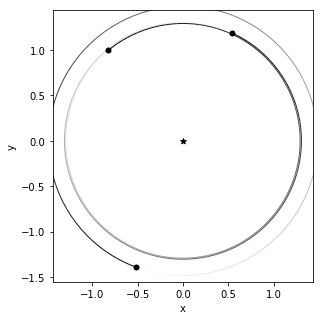

In [4]:
sim = rebound.SimulationArchive(sim_names + sa_names[0])[0]
print([sim.particles[1+i].P for i in range(3)])
print([sim.particles[1+i].r for i in range(3)])
# print(features(sim, features_args))
rebound.OrbitPlot(sim)

# Calculating features

In [47]:
Norbits = 1e4
Nout = 80
trios = [[i,i+1,i+2] for i in range(1,sim.N_real-2)]
features_args = [Norbits, Nout] + [trios]

def calculate_features(row):
    res, stable = features(rebound.SimulationArchive(sim_names + "sims/" + row["sim"])[0], features_args)
    r = res[0]
    return pd.Series(r, index=list(r.keys()))

In [48]:
# %%time
df = pd.DataFrame(data=sa_names, columns=["sim"])
ddf = dd.from_pandas(df, npartitions=n_workers)
testres = calculate_features(df.loc[0])
metadf = pd.DataFrame([testres])
# feats = ddf.apply(calculate_features, axis=1, meta=metadf).compute(scheduler='processes')
# feats.to_csv(sim_names + "trainingdata.csv")
feats = pd.read_csv(sim_names + "trainingdata.csv", index_col=0)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


TypeError: 'list' object is not callable

In [ ]:
# # %%time
# # hmm = pd.DataFrame(features(rebound.SimulationArchive(sim_names + sa_names[0])[0], features_args)[0])
# # for i in range(1,10):
# #     hmm = hmm.append(pd.DataFrame(ff.features(rebound.SimulationArchive(sim_names + sa_names[i])[0], features_args)[0]), ignore_index=True)
# # hmm["sim"] = sa_names[:10]

# Are systems truly stable?

In [80]:
def system_stable(nsim):
    sim = rebound.SimulationArchive(sim_names + sa_names[nsim])[0]
    P1 = sim.particles[1].P
    try:
        sim.integrate(1e6 * P1, exact_finish_time=0)
        return True
    except:
        return False

In [81]:
# %%time
# system_stable(1)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


CPU times: user 15.4 s, sys: 10 ms, total: 15.4 s
Wall time: 15.3 s


True

In [82]:
# %%time
# pool = Pool(processes=n_workers)
# nsim_list = np.arange(0, n)
# res = pool.map(system_stable, nsim_list)
# df = pd.DataFrame(data=sa_names, columns=["sim"])
# df["stability"] = res
# df.to_csv("sim_names + "labels.csv")

CPU times: user 6.93 s, sys: 1.49 s, total: 8.43 s
Wall time: 24min 16s


In [67]:
# stab = np.array(np.ones(n), dtype=bool)
# for i in range(n):
#     try:
#         stab[i] = pd.read_csv(sim_names + "sims/" + sa_names[i] + "_stab.csv", index_col=0)["stability"][0]
#     except:
#         continue
# df = pd.DataFrame(data=sa_names, columns=["sim"])
# df["Stable"] = stab
# df.to_csv(sim_names + "labels.csv")
stab = pd.read_csv(sim_names + "labels.csv", index_col=0)
# stab

# Training models!

## MEGNO

In [81]:
# datapath = '../Dan_research/spock/training_data/'
# dset = 'resonant/'
# Norbits = 1e4
# Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
# featurefolder = 'additional_featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
# trainingdatafolder = datapath+dset+featurefolder
datapath = sim_names
featurefolder = sim_names
trainingdatafolder = sim_names

In [40]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [50]:
features = ['MEGNO']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [51]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.88824576                                            
ERROR                                                 
0.02383992815223841                                   
SCORE:                                                
0.88539166                                                              
ERROR                                                                   
0.02321627987623114                                                     
SCORE:                                                                  
0.87202202                                                              
ERROR                                                                   
0.026597761760685568                                                    
SCORE:                                                                  
0.8865834400000001                                                      
ERROR                                                               

SCORE:                                                                            
0.8935677400000002                                                                
ERROR                                                                             
0.022709611980989745                                                              
SCORE:                                                                            
0.8903843800000001                                                                
ERROR                                                                             
0.02582086590768079                                                               
SCORE:                                                                            
0.8903333799999998                                                                
ERROR                                                                             
0.021502534641885937                                                              
SCOR

In [52]:
best

{'x_learning_rate': 0.09846322775310665,
 'x_max_depth': 5,
 'x_min_child': 2.0,
 'x_pos_weight': 7.8575876782609715,
 'x_subsample': 0.9806958528688635,
 'x_tree_colsample': 0.8703651258790678}

In [53]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.894697+0.00566713	test-auc:0.883202+0.0278597
[1]	train-auc:0.895558+0.00508818	test-auc:0.883249+0.0278737
[2]	train-auc:0.89613+0.00495532	test-auc:0.883295+0.0279026
[3]	train-auc:0.896445+0.00545399	test-auc:0.883264+0.027883
[4]	train-auc:0.896455+0.00544859	test-auc:0.883265+0.027884
[5]	train-auc:0.897766+0.00675998	test-auc:0.884588+0.0252732
[6]	train-auc:0.89823+0.00641073	test-auc:0.886748+0.0257494
[7]	train-auc:0.898997+0.00572086	test-auc:0.889596+0.0275126
[8]	train-auc:0.899028+0.00570791	test-auc:0.889596+0.0275126
[9]	train-auc:0.900431+0.00519606	test-auc:0.891066+0.0284377


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8703651258790678, gamma=0,
              learning_rate=0.09846322775310665, max_delta_step=0, max_depth=5,
              min_child_weight=2.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.8575876782609715,
              seed=None, silent=None, subsample=0.9806958528688635,
              verbosity=1)

In [60]:
model.save_model(trainingdatafolder+'/models/megno.bin')

dill.dump([model, features, featureargs, featurefolder], open(trainingdatafolder + "/models/megno.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.887)')

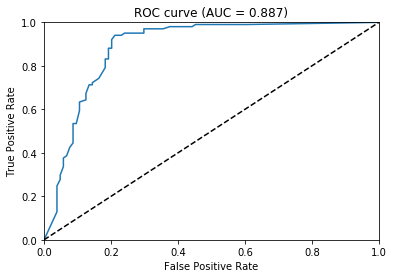

In [68]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [70]:
model, features, featureargs, featurefolder = dill.load(open(trainingdatafolder + '/models/megno.pkl', 'rb'))

In [71]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.99420964717865, TPR = 0.0, FPR = 0.0
Threshold 0.9792628884315491, TPR = 0.5346534653465347, FPR = 0.09615384615384616
Threshold 0.9719792008399963, TPR = 0.8316831683168316, FPR = 0.19230769230769232
Threshold 0.35508063435554504, TPR = 0.9702970297029703, FPR = 0.3557692307692308


## AMD and Hill soon

In [75]:
features = ['AMDtriofracnear', 'AMDtriofracfar']
features = ['betanear', 'betafar']

## Full

In [76]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [77]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [78]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.95764378                                            
ERROR                                                 
0.013074077202918064                                  
SCORE:                                                                            
0.9578627599999999                                                                
ERROR                                                                             
0.014190473407599925                                                              
SCORE:                                                                            
0.88268038                                                                        
ERROR                                                                             
0.028295516009821713                                                              
SCORE:                                                                            
0.9558031399999999               

0.011754771402779987                                                              
SCORE:                                                                            
0.9607342800000002                                                                
ERROR                                                                             
0.010281673011562378                                                              
SCORE:                                                                            
0.9590548                                                                         
ERROR                                                                             
0.011990612737691388                                                              
SCORE:                                                                            
0.9590661                                                                         
ERROR                                                                             
0.00

0.9572274000000001                                                                
ERROR                                                                             
0.01259636875550579                                                               
100%|██████████| 50/50 [00:05<00:00,  8.64trial/s, best loss: 0.03926571999999984]
Optimization Time: %f seconds 5.429235219955444
CPU times: user 4.75 s, sys: 178 ms, total: 4.92 s
Wall time: 5.43 s


In [79]:
best

{'x_learning_rate': 0.08785653551559526,
 'x_max_depth': 9,
 'x_min_child': 8.0,
 'x_pos_weight': 18.823981360786952,
 'x_subsample': 0.9270438687013021,
 'x_tree_colsample': 0.9356965449558142}

In [80]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.900794+0.0102875	test-auc:0.895489+0.0252852
[1]	train-auc:0.939007+0.0124735	test-auc:0.92339+0.0134939
[2]	train-auc:0.946011+0.00808784	test-auc:0.926886+0.0154876
[3]	train-auc:0.961083+0.0121413	test-auc:0.93335+0.0146152
[4]	train-auc:0.963378+0.0122923	test-auc:0.934476+0.0151152
[5]	train-auc:0.967895+0.0119057	test-auc:0.936296+0.0147491
[6]	train-auc:0.971813+0.01075	test-auc:0.945011+0.0183396
[7]	train-auc:0.972187+0.0109602	test-auc:0.945283+0.0189777
[8]	train-auc:0.973094+0.00924573	test-auc:0.946087+0.019398
[9]	train-auc:0.973516+0.00924284	test-auc:0.945808+0.0192582


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9356965449558142, gamma=0,
              learning_rate=0.08785653551559526, max_delta_step=0, max_depth=9,
              min_child_weight=8.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=18.823981360786952,
              seed=None, silent=None, subsample=0.9270438687013021,
              verbosity=1)

In [82]:
model.save_model(datapath+'/models/spock.json')

In [84]:
model = XGBClassifier()
model.load_model(datapath+'/models/spock.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.957)')

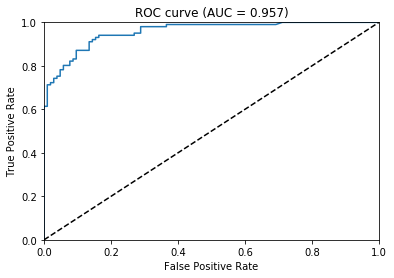

In [85]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.957)')

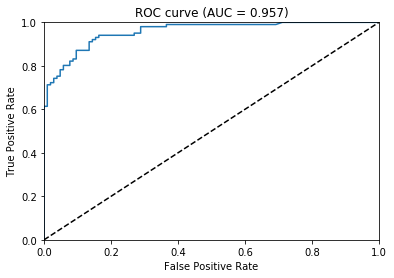

In [86]:
#model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
#testingdatafolder = datapath+testing_dataset+'/'+featurefolder
#roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features, filtertimes=True)

roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [87]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9996434450149536, TPR = 0.0, FPR = 0.0
Threshold 0.9844551086425781, TPR = 0.801980198019802, FPR = 0.057692307692307696
Threshold 0.44192221760749817, TPR = 0.9405940594059405, FPR = 0.2692307692307692
Threshold 0.0007439604960381985, TPR = 1.0, FPR = 0.8365384615384616


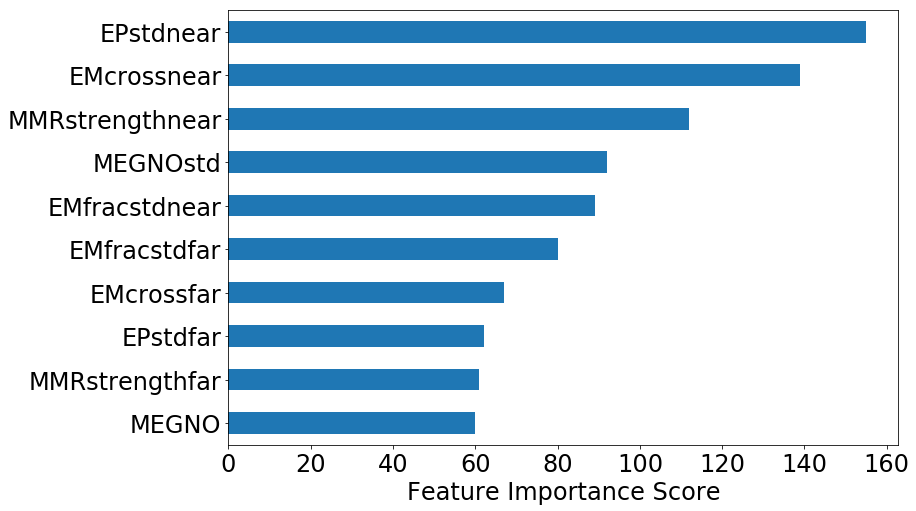

In [88]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0, 24.200000000000003)

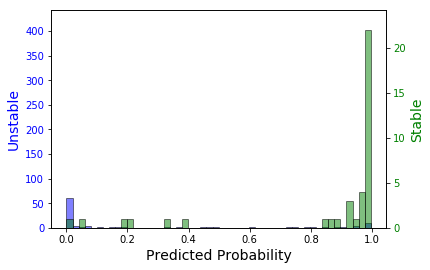

In [89]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

../Dan_research/spock/spock/modelfitting.py:89: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio.
../Dan_research/spock/spock/modelfitting.py:89: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio.


Text(0, 0.5, 'Fraction actually stable')

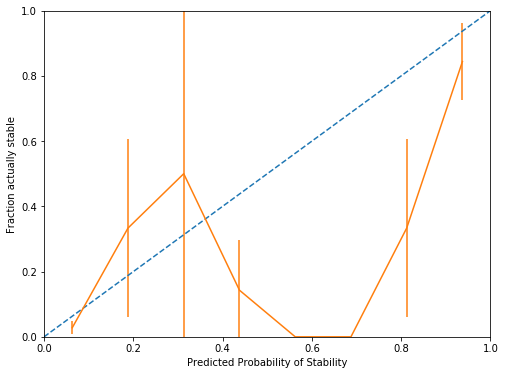

In [90]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

In [91]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

KeyError: 'instability_time'